In [1]:
import sys
sys.path.append('../')

In [32]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import Normalize, ListedColormap
from matplotlib import cm
import pandas as pd
import numpy as np
from scipy import stats
from constants import *
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, SimpleImputer, IterativeImputer
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold
import dateutil.parser
import impyute
import random
import xgboost
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from scipy.interpolate import griddata
import pickle as pkl
from shapely.geometry import Point

In [3]:
bihar = gpd.read_file(r'../data/Bihar/bihar.json')
data_file = f'{data_bihar}/Bihar_419_data_modified.csv'

In [4]:
df = pd.DataFrame(columns={'timestamp': pd.Timestamp, 'latitude': np.float64, 'longitude': np.float64, 'rh': np.float32,\
                           'temp': np.float64, 'pm25': np.float64})

df = df.append(pd.read_csv(data_file, parse_dates=['timestamp']))

In [5]:
grp = df.groupby('timestamp')
# print(grp.count())

idx = []

for i, (name, group) in enumerate(grp):
    if group['pm25'].count() > 300:
        idx = [491*i, 491*i+490]
        print(i, group['pm25'].count())
        break

5 304


In [6]:
df.dtypes

timestamp    datetime64[ns]
latitude            float64
longitude           float64
rh                  float64
temp                float64
pm25                float64
dtype: object

In [7]:
df['timestamp'] = df['timestamp'].values.astype(float)

In [8]:
def impute(data, method):
    assert method == 'knn' or method == 'mean' or method == 'iterative', 'method can only knn, mean or iterative'
    # KNN Imputer
    if method == 'knn':
        imputer = KNNImputer(n_neighbors=2)
    # Mean Imputer
    elif method == 'mean':
        imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    # Iterative Imputer
    elif method == 'iterative':
        imputer = IterativeImputer(random_state=0)
    
    return imputer.fit_transform(data)

In [9]:
impute_data = impute(df.to_numpy(), 'iterative')

In [10]:
file_path = f'{model_dir}/bihar_xgb_iterative.pkl'
model = pkl.load(open(file_path, "rb"))

In [11]:
preds = model.predict(impute_data[:, :-1])

In [12]:
preds

array([ 5.2262316, 11.8145275,  6.900817 , ..., 29.238592 , 32.2019   ,
       27.274385 ], dtype=float32)

In [13]:
cnt = np.sum(np.isnan(preds))
cnt

0

In [14]:
data = {}
data['lat'] = impute_data[idx[0]:idx[1], 1]
data['long'] = impute_data[idx[0]:idx[1], 2]
data['pm25'] = preds[idx[0]:idx[1]]

In [81]:
# for keys in bihar['geometry']:
#     print(keys)

POLYGON ((84.50294045212107 26.60291125570179, 84.48737038297782 26.60608465879179, 84.48550197468063 26.6179849203793, 84.45685304745706 26.62486062707431, 84.45778725160565 26.63305858505681, 84.41232264970736 26.58360638690428, 84.43225233821072 26.6140181665168, 84.42882692299921 26.63649643840431, 84.4182392759818 26.63173633376931, 84.4173050718332 26.63755423943432, 84.41325685385596 26.63808313994932, 84.41076564279304 26.67008162110684, 84.33042408601389 26.68409748475435, 84.30613477815042 26.7496811486144, 84.2858936882642 26.7502100491294, 84.25101673338332 26.73064073007439, 84.24914832508614 26.72958292904439, 84.24541150849176 26.73513638445189, 84.2326440517943 26.75364790247691, 84.25973597210354 26.80415790165944, 84.25973597210354 26.80468680217444, 84.25039393061759 26.81923156633696, 84.25911316933781 26.83694973358947, 84.25599915550916 26.84884999517698, 84.24665711402322 26.85969245573449, 84.21956519371396 26.871592717322, 84.19029346372466 26.85863465470449, 8

In [76]:
min_lat, max_lat, min_long, max_long = float('inf'), float('-inf'), float('inf'), float('-inf')
for vertex in (bihar['geometry'])['coordinates']:
    min_lat, max_lat = min(min_lat, vertex[1]), max(max_lat, vertex[1])
    min_long, max_long = min(min_long, vertex[0]), max(max_long, vertex[0])

KeyError: 'coordinates'

In [15]:
min_lat, max_lat = df['latitude'].min(), df['latitude'].max()
min_long, max_long = df['longitude'].min(), df['longitude'].max()
print(min_lat, max_lat, min_long, max_long)

24.443 27.308 83.4 88.172


In [59]:
grid_lat, grid_long = np.meshgrid(np.linspace(min_lat, max_lat, 400), np.linspace(min_long, max_long, 400))
grid_values = griddata((data['lat'], data['long']), data['pm25'], (grid_lat, grid_long), method='nearest')

In [60]:
grid_values.shape

(400, 400)

In [61]:
def favorable_points(long, lat):
    return [Point(x, y) for x, y in zip(long, lat)]

In [62]:
points = []
for long, lat in zip(grid_long, grid_lat):
    points.append(favorable_points(long, lat))

In [63]:
data_long, data_lat, values = [], [], []

In [64]:
# for point, val in zip(points, grid_values):
#     for p, pm25 in zip(point, val):
#         if (bihar.geometry.contains(p).any()):
#             data_long.append(p.x)
#             data_lat.append(p.y)
#             values.append(pm25)

In [65]:
valid_points = [(p.x, p.y, pm25) for point, val in zip(points, grid_values) for p, pm25 in zip(point, val) if bihar.geometry.contains(p).any()]

# Unpack the valid points into separate lists
data_long, data_lat, values = zip(*valid_points)
# values = stats.zscore(values)

In [66]:
np.sum(np.isnan(np.array(values)))

0

c:\Users\malay\miniconda3\envs\cs776\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("jet").copy()
  """
c:\Users\malay\miniconda3\envs\cs776\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("jet").copy()
  


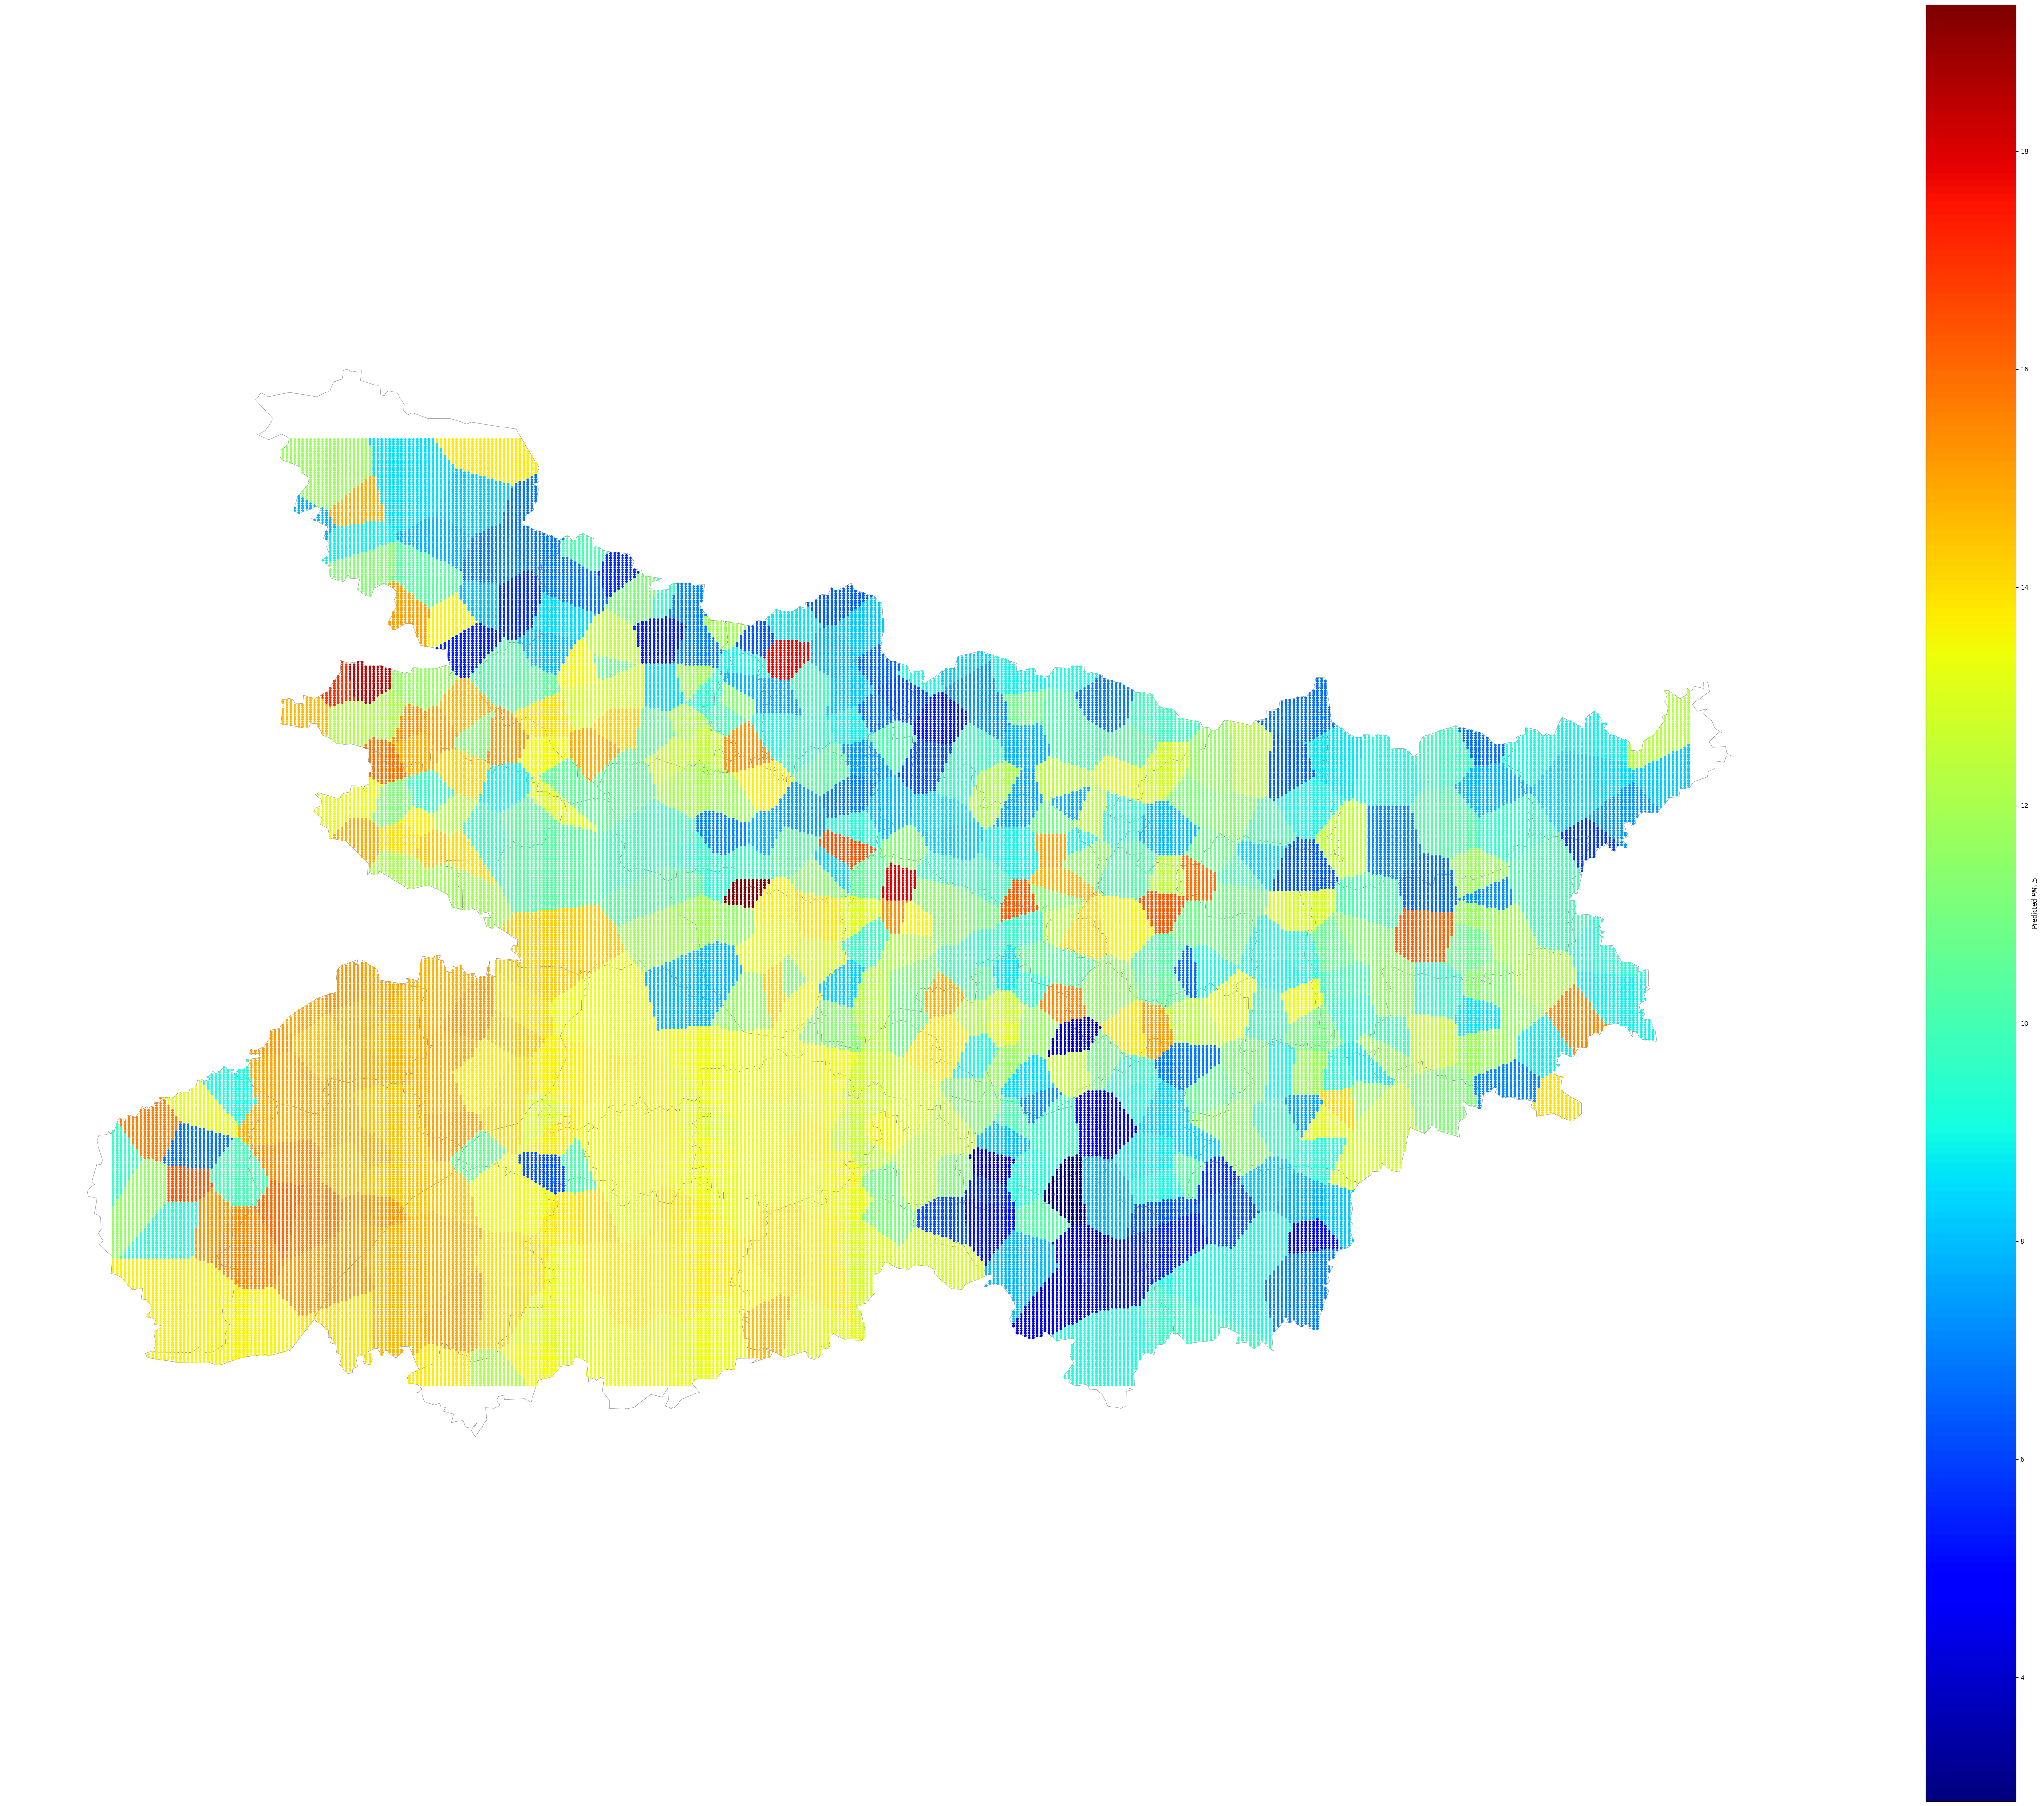

In [67]:
fig, ax = plt.subplots(figsize=(62.5, 50))

norm = Normalize(vmin=min(values), vmax=max(values))
my_cmap = cm.get_cmap('jet')
my_cmap.set_over('darkred')
my_cmap.set_under('blue')

bihar.plot(ax=ax, color='white', edgecolor='grey', linewidth=0.5)
scatter = ax.scatter(data_long, data_lat, c=values, cmap=my_cmap, marker='.')
cbar = plt.colorbar(scatter, ax=ax, label=f'Predicted $PM_{2.5}$')

ax.set_axis_off()
plt.savefig('map_2.png', dpi=400)
plt.show()